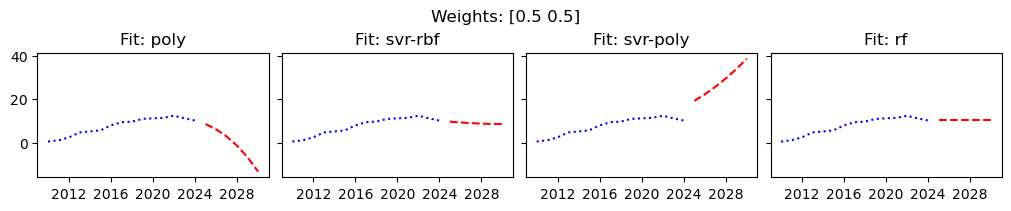

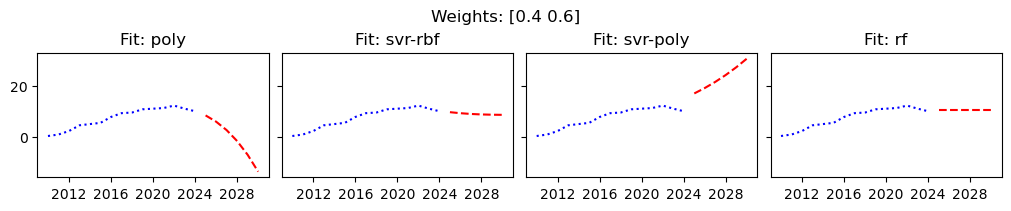

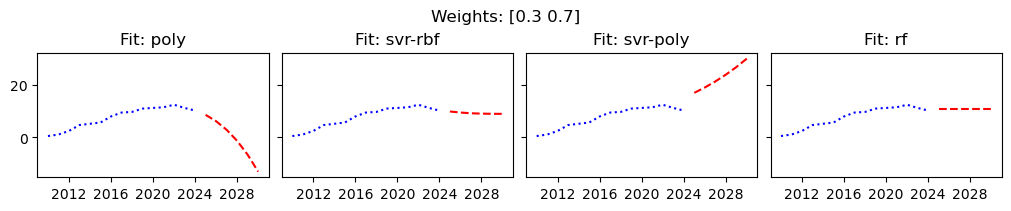

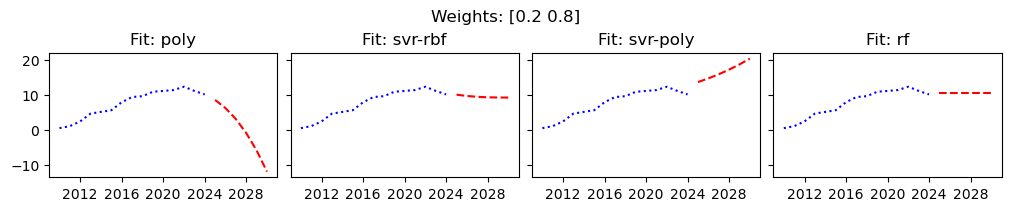

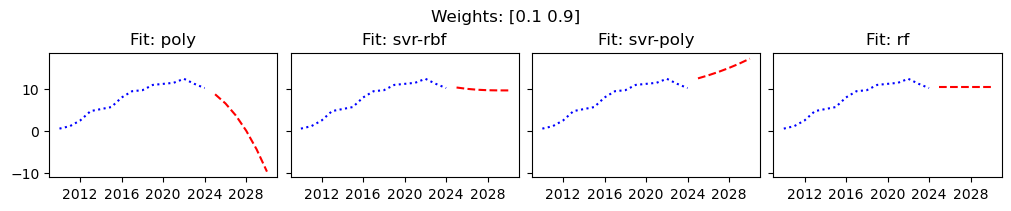

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from typing import List
from typing_extensions import Annotated

import xgboost as XGBRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def set_weights(series, w: list):
    """Set weights for weighted regression."""

    # FIXME Here, the slice should be automated to allow not only 5 and 5:15, but adapt to input data.

    weights = np.ones(len(series))
    weights[:5] = w[0]  # past window weight
    weights[5:15] = w[1]  # common window weight

    return weights


def generate_weight_pairs_matrix(weight_a, weight_b, n):
    """Generate matrix with weight lists [wa, wb], such that wa + wb = 1 for tests."""

    # matrix columns
    col2 = np.linspace(weight_a, weight_b, n)
    col1 = 1 - col2

    # matrix
    weight_pairs = np.column_stack((col1, col2))

    return weight_pairs


def fit_model(
    X,
    y,
    model: str,
    weights: Annotated[List[float], "List of past- and common-windou weights [wp, wc]"],
):
    """Select models for weighted regression."""

    # weights
    weights = set_weights(y, weights)

    # reshape input for 2D
    X = X.reshape(-1, 1)

    if model == "poly":
        M = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
        M.fit(X, y, linearregression__sample_weight=weights)

    elif model == "svr-rbf":
        M = SVR(kernel="rbf")  # ou 'poly' para polinomial
        M.fit(X, series, sample_weight=weights)

    elif model == "svr-poly":
        M = SVR(kernel="poly")  # ou 'poly' para polinomial
        M.fit(X, series, sample_weight=weights)

    elif model == "rf":
        M = RandomForestRegressor(n_estimators=100)
        M.fit(X, series, sample_weight=weights)

    # elif model == "xgb":
    #     M = XGBRegressor()
    #     M.fit(X, series, sample_weight=weights)

    return M


# Simulated series
np.random.seed(42)

past = pd.date_range("2010", periods=15, freq="YS")  # past and common (2010-2024)
future = pd.date_range("2025", periods=6, freq="YS")  # future (2025-2030)
series = np.random.randn(15).cumsum() + np.linspace(0, 10, 15)  # series

# Convert to numeric
past_numeric = np.arange(len(past))
future_numeric = np.arange(len(past), len(past) + len(future))

# Selector
# models = ["poly", "svr-rbf", "svr-poly", "rf", "xgb"]
models = ["poly", "svr-rbf", "svr-poly", "rf"]

# Weight matrix
W = generate_weight_pairs_matrix(0.5, 0.9, n=5)

for weights in W:

    fig, ax = plt.subplots(
        1, len(models), figsize=(10, 2), sharey=True, constrained_layout=True
    )
    fig.suptitle(f"Weights: {weights}")

    for i, model in enumerate(models):

        # fit / predict
        M = fit_model(past_numeric, series, model, weights)
        y_pred = M.predict(future_numeric.reshape(-1, 1))

        # plot
        ax[i].plot(past, series, "b:")
        ax[i].plot(future, y_pred, "r--")
        ax[i].set_title(f"Fit: {model}")